# CS2 HLTV Data - Exploratory Data Analysis

This notebook performs an exploratory data analysis on CS2 match data scraped from HLTV.
We'll analyze:
- Players and their performance metrics
- Map statistics and win rates
- Veto patterns
- Player stats across different sides (CT/TR)

## 1. Setup and Data Loading

In [26]:
# Import necessary libraries
import polars as pl
import sys
from pathlib import Path
import numpy as np

# Add the src directory to the path
sys.path.insert(0, str(Path.cwd().parent / "src"))

from db.config import get_database_url

# Import visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

print("Libraries imported successfully!")

Libraries imported successfully!


In [27]:
# Get database connection string
db_url = get_database_url(make_ipv6_in_bracket=True)

# Load all tables into Polars dataframes
events = pl.read_database_uri("SELECT * FROM events", db_url)
teams = pl.read_database_uri("SELECT * FROM teams", db_url)
players = pl.read_database_uri("SELECT * FROM players", db_url)
matches = pl.read_database_uri("SELECT * FROM matches", db_url)
vetos = pl.read_database_uri("SELECT * FROM vetos", db_url)
map_stats = pl.read_database_uri("SELECT * FROM map_stats", db_url)
player_map_stats = pl.read_database_uri("SELECT * FROM player_map_stats", db_url)

print("Data loaded successfully!")
print(f"Events: {len(events)} rows")
print(f"Teams: {len(teams)} rows")
print(f"Players: {len(players)} rows")
print(f"Matches: {len(matches)} rows")
print(f"Vetos: {len(vetos)} rows")
print(f"Map Stats: {len(map_stats)} rows")
print(f"Player Map Stats: {len(player_map_stats)} rows")

Data loaded successfully!
Events: 102 rows
Teams: 317 rows
Players: 1639 rows
Matches: 1208 rows
Vetos: 1208 rows
Map Stats: 2681 rows
Player Map Stats: 26723 rows


## 2. Data Overview and Basic Statistics

In [28]:
# Overview of the data
print("=== EVENTS ===")
print(events.head())
print(f"\nShape: {events.shape}")
print(f"\nSchema:\n{events.schema}")

print("\n\n=== TEAMS ===")
print(teams.head())
print(f"\nShape: {teams.shape}")
print(f"\nTop 10 teams:")
print(teams.head(10))

=== EVENTS ===
shape: (5, 2)
┌──────────┬─────────────────────────────────┐
│ event_id ┆ name                            │
│ ---      ┆ ---                             │
│ i32      ┆ str                             │
╞══════════╪═════════════════════════════════╡
│ 8873     ┆ Dust2.us Eagle Masters Series … │
│ 8865     ┆ CCT Season 3 Europe Series 12   │
│ 8870     ┆ Wraith TESFED League Season 2   │
│ 8042     ┆ StarLadder Budapest Major 2025  │
│ 8857     ┆ NODWIN Clutch Series 3          │
└──────────┴─────────────────────────────────┘

Shape: (102, 2)

Schema:
Schema({'event_id': Int32, 'name': String})


=== TEAMS ===
shape: (5, 2)
┌─────────┬──────────────────┐
│ team_id ┆ name             │
│ ---     ┆ ---              │
│ i32     ┆ str              │
╞═════════╪══════════════════╡
│ 7720    ┆ InControl        │
│ 11955   ┆ LAG              │
│ 7532    ┆ BIG              │
│ 10333   ┆ Sangal           │
│ 13281   ┆ Bushido Wildcats │
└─────────┴──────────────────┘

Shape: (317,

In [29]:
print("=== PLAYERS ===")
print(players.head(10))
print(f"\nTotal players: {len(players)}")
print(f"\nSchema:\n{players.schema}")

print("\n\n=== MATCHES ===")
print(matches.head())
print(f"\nShape: {matches.shape}")
print(f"\nSchema:\n{matches.schema}")
print(
    f"\nMatch date range: {matches['match_date'].min()} to {matches['match_date'].max()}"
)

=== PLAYERS ===
shape: (10, 2)
┌───────────┬───────────┐
│ player_id ┆ name      │
│ ---       ┆ ---       │
│ i32       ┆ str       │
╞═══════════╪═══════════╡
│ 14744     ┆ calamity  │
│ 20330     ┆ jsfeltner │
│ 24234     ┆ aelor     │
│ 23690     ┆ TyRa      │
│ 24528     ┆ Scorchyy  │
│ 19177     ┆ consti    │
│ 22552     ┆ Sandman   │
│ 12102     ┆ djay      │
│ 21128     ┆ Pluto     │
│ 20572     ┆ kmrn      │
└───────────┴───────────┘

Total players: 1639

Schema:
Schema({'player_id': Int32, 'name': String})


=== MATCHES ===
shape: (5, 8)
┌──────────┬──────────┬─────────────┬───────────┬───────────┬────────────┬────────────┬────────────┐
│ match_id ┆ event_id ┆ match_date  ┆ team_1_id ┆ team_2_id ┆ team_1_map ┆ team_2_map ┆ team_winne │
│ ---      ┆ ---      ┆ ---         ┆ ---       ┆ ---       ┆ _score     ┆ _score     ┆ r_id       │
│ i32      ┆ i32      ┆ datetime[μs ┆ i32       ┆ i32       ┆ ---        ┆ ---        ┆ ---        │
│          ┆          ┆ , UTC]      ┆     

In [30]:
print("=== MAP STATS ===")
print(map_stats.head())
print(f"\nShape: {map_stats.shape}")
print(f"\nSchema:\n{map_stats.schema}")

print("\n\n=== PLAYER MAP STATS ===")
print(player_map_stats.head())
print(f"\nShape: {player_map_stats.shape}")
print(f"\nSchema:\n{player_map_stats.schema}")

=== MAP STATS ===
shape: (5, 13)
┌────────────┬──────────┬──────────┬───────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ map_stat_i ┆ match_id ┆ map_name ┆ team_1_sc ┆ … ┆ team_2_ct ┆ team_2_tr ┆ picked_by ┆ starting_ │
│ d          ┆ ---      ┆ ---      ┆ ore       ┆   ┆ _score    ┆ _score    ┆ ---       ┆ ct        │
│ ---        ┆ i32      ┆ str      ┆ ---       ┆   ┆ ---       ┆ ---       ┆ str       ┆ ---       │
│ i32        ┆          ┆          ┆ i32       ┆   ┆ i32       ┆ i32       ┆           ┆ str       │
╞════════════╪══════════╪══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 215414     ┆ 2388654  ┆ Inferno  ┆ 3         ┆ … ┆ 9         ┆ 4         ┆ team_2    ┆ team_1    │
│ 215417     ┆ 2388654  ┆ Nuke     ┆ 16        ┆ … ┆ 7         ┆ 5         ┆ team_1    ┆ team_2    │
│ 215420     ┆ 2388654  ┆ Train    ┆ 1         ┆ … ┆ 11        ┆ 2         ┆ leftover  ┆ team_1    │
│ 215442     ┆ 2388447  ┆ Train    ┆ 13        ┆ … ┆ 2    

## 3. Map Analysis

=== MAP POPULARITY ===
shape: (7, 6)
┌──────────┬──────────────┬─────────────────┬─────────────────┬──────────────┬──────────────┐
│ map_name ┆ times_played ┆ avg_team1_score ┆ avg_team2_score ┆ avg_team1_ot ┆ avg_team2_ot │
│ ---      ┆ ---          ┆ ---             ┆ ---             ┆ ---          ┆ ---          │
│ str      ┆ u32          ┆ f64             ┆ f64             ┆ f64          ┆ f64          │
╞══════════╪══════════════╪═════════════════╪═════════════════╪══════════════╪══════════════╡
│ Ancient  ┆ 472          ┆ 10.96822        ┆ 10.506356       ┆ 3.56         ┆ 3.68         │
│ Dust2    ┆ 456          ┆ 11.118421       ┆ 10.932018       ┆ 3.21519      ┆ 4.696203     │
│ Nuke     ┆ 429          ┆ 10.86014        ┆ 10.333333       ┆ 2.78         ┆ 4.32         │
│ Mirage   ┆ 424          ┆ 11.014151       ┆ 10.242925       ┆ 3.095238     ┆ 4.428571     │
│ Inferno  ┆ 367          ┆ 10.689373       ┆ 10.457766       ┆ 2.868421     ┆ 4.447368     │
│ Train    ┆ 281       

/tmp/ipykernel_255610/3768351828.py:6: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  pl.count().alias("times_played"),


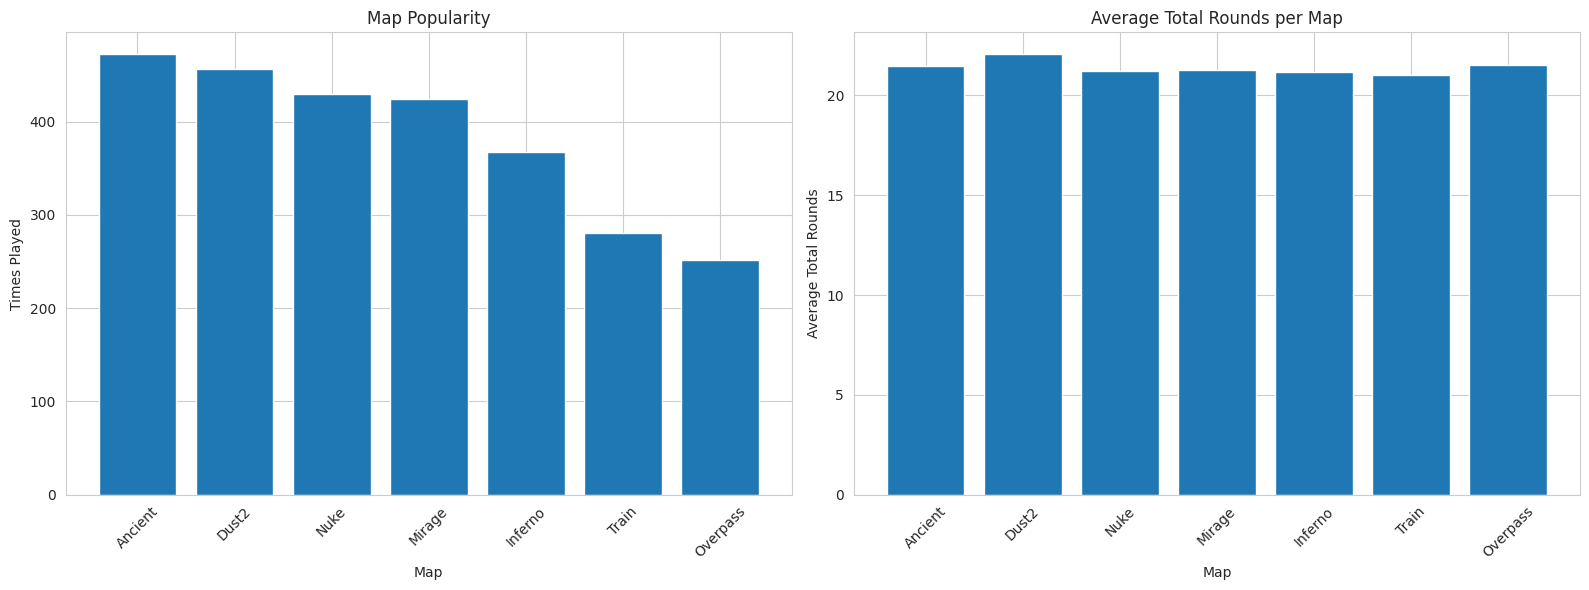

In [31]:
# Map popularity and statistics
map_popularity = (
    map_stats.group_by("map_name")
    .agg(
        [
            pl.count().alias("times_played"),
            pl.mean("team_1_score").alias("avg_team1_score"),
            pl.mean("team_2_score").alias("avg_team2_score"),
            pl.mean("team_1_overtime_score").alias("avg_team1_ot"),
            pl.mean("team_2_overtime_score").alias("avg_team2_ot"),
        ]
    )
    .sort("times_played", descending=True)
)

print("=== MAP POPULARITY ===")
print(map_popularity)

# Visualize map popularity
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Map play frequency
map_data = map_popularity.to_pandas()
ax1.bar(map_data["map_name"], map_data["times_played"])
ax1.set_xlabel("Map")
ax1.set_ylabel("Times Played")
ax1.set_title("Map Popularity")
ax1.tick_params(axis="x", rotation=45)

# Average scores per map
map_data["avg_total_score"] = map_data["avg_team1_score"] + map_data["avg_team2_score"]
ax2.bar(map_data["map_name"], map_data["avg_total_score"])
ax2.set_xlabel("Map")
ax2.set_ylabel("Average Total Rounds")
ax2.set_title("Average Total Rounds per Map")
ax2.tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

=== CT vs T SIDE PERFORMANCE BY MAP ===
shape: (7, 4)
┌──────────┬──────────────┬─────────────┬─────────┐
│ map_name ┆ avg_ct_score ┆ avg_t_score ┆ n_games │
│ ---      ┆ ---          ┆ ---         ┆ ---     │
│ str      ┆ f64          ┆ f64         ┆ u32     │
╞══════════╪══════════════╪═════════════╪═════════╡
│ Ancient  ┆ 6.0          ┆ 4.353814    ┆ 472     │
│ Dust2    ┆ 6.0          ┆ 4.339912    ┆ 456     │
│ Nuke     ┆ 6.001166     ┆ 4.181818    ┆ 429     │
│ Mirage   ┆ 6.001179     ┆ 4.254717    ┆ 424     │
│ Inferno  ┆ 6.0          ┆ 4.194823    ┆ 367     │
│ Train    ┆ 6.0          ┆ 4.115658    ┆ 281     │
│ Overpass ┆ 6.0          ┆ 4.337302    ┆ 252     │
└──────────┴──────────────┴─────────────┴─────────┘


/tmp/ipykernel_255610/1133246009.py:10: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  pl.count().alias("n_games"),


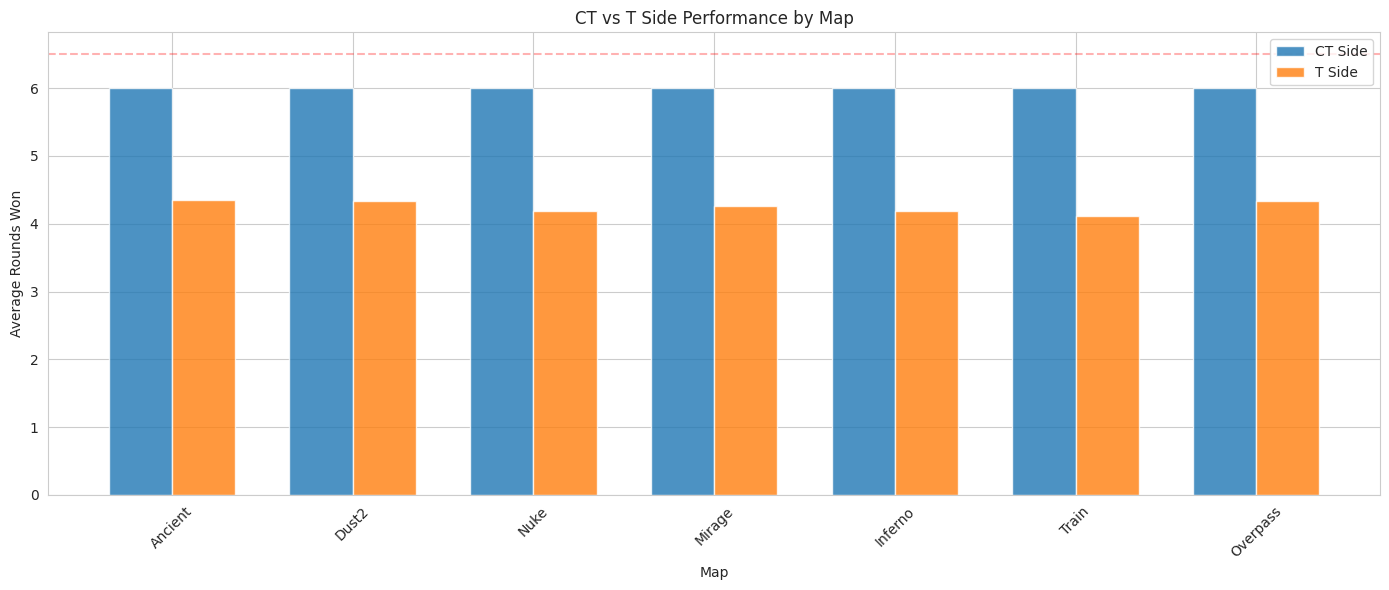

In [32]:
# CT vs T side performance by map
ct_t_analysis = (
    map_stats.group_by("map_name")
    .agg(
        [
            pl.mean("team_1_ct_score").alias("avg_ct_score_t1"),
            pl.mean("team_1_tr_score").alias("avg_t_score_t1"),
            pl.mean("team_2_ct_score").alias("avg_ct_score_t2"),
            pl.mean("team_2_tr_score").alias("avg_t_score_t2"),
            pl.count().alias("n_games"),
        ]
    )
    .with_columns(
        [
            ((pl.col("avg_ct_score_t1") + pl.col("avg_ct_score_t2")) / 2).alias(
                "avg_ct_score"
            ),
            ((pl.col("avg_t_score_t1") + pl.col("avg_t_score_t2")) / 2).alias(
                "avg_t_score"
            ),
        ]
    )
    .select(["map_name", "avg_ct_score", "avg_t_score", "n_games"])
    .sort("n_games", descending=True)
)

print("=== CT vs T SIDE PERFORMANCE BY MAP ===")
print(ct_t_analysis)

# Visualize CT vs T balance
ct_t_data = ct_t_analysis.to_pandas()
x = range(len(ct_t_data))
width = 0.35

fig, ax = plt.subplots(figsize=(14, 6))
ax.bar(
    [i - width / 2 for i in x],
    ct_t_data["avg_ct_score"],
    width,
    label="CT Side",
    alpha=0.8,
)
ax.bar(
    [i + width / 2 for i in x],
    ct_t_data["avg_t_score"],
    width,
    label="T Side",
    alpha=0.8,
)
ax.set_xlabel("Map")
ax.set_ylabel("Average Rounds Won")
ax.set_title("CT vs T Side Performance by Map")
ax.set_xticks(x)
ax.set_xticklabels(ct_t_data["map_name"], rotation=45)
ax.legend()
ax.axhline(
    y=6.5, color="r", linestyle="--", alpha=0.3, label="Expected (6.5 rounds per side)"
)
plt.tight_layout()
plt.show()

In [33]:
# Overtime analysis
overtime_stats = (
    map_stats.filter(
        (pl.col("team_1_overtime_score").is_not_null())
        | (pl.col("team_2_overtime_score").is_not_null())
    )
    .group_by("map_name")
    .agg(
        [
            pl.count().alias("overtime_games"),
            pl.mean("team_1_overtime_score").alias("avg_ot_score_t1"),
            pl.mean("team_2_overtime_score").alias("avg_ot_score_t2"),
        ]
    )
    .sort("overtime_games", descending=True)
)

print("=== OVERTIME STATISTICS BY MAP ===")
print(overtime_stats)

total_maps = len(map_stats)
total_ot = len(
    map_stats.filter(
        (pl.col("team_1_overtime_score").is_not_null())
        | (pl.col("team_2_overtime_score").is_not_null())
    )
)
print(f"\nOvertime rate: {total_ot}/{total_maps} ({100 * total_ot / total_maps:.1f}%)")

=== OVERTIME STATISTICS BY MAP ===
shape: (7, 4)
┌──────────┬────────────────┬─────────────────┬─────────────────┐
│ map_name ┆ overtime_games ┆ avg_ot_score_t1 ┆ avg_ot_score_t2 │
│ ---      ┆ ---            ┆ ---             ┆ ---             │
│ str      ┆ u32            ┆ f64             ┆ f64             │
╞══════════╪════════════════╪═════════════════╪═════════════════╡
│ Dust2    ┆ 79             ┆ 3.21519         ┆ 4.696203        │
│ Ancient  ┆ 50             ┆ 3.56            ┆ 3.68            │
│ Nuke     ┆ 50             ┆ 2.78            ┆ 4.32            │
│ Mirage   ┆ 42             ┆ 3.095238        ┆ 4.428571        │
│ Inferno  ┆ 38             ┆ 2.868421        ┆ 4.447368        │
│ Train    ┆ 31             ┆ 2.580645        ┆ 4.548387        │
│ Overpass ┆ 27             ┆ 3.37037         ┆ 4.481481        │
└──────────┴────────────────┴─────────────────┴─────────────────┘

Overtime rate: 317/2681 (11.8%)


/tmp/ipykernel_255610/1934323854.py:10: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  pl.count().alias("overtime_games"),


## 4. Veto Analysis

/tmp/ipykernel_255610/1178231288.py:5: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  best_of_dist = vetos.group_by("best_of").agg(pl.count().alias("count")).sort("best_of")


=== VETO DATA OVERVIEW ===
shape: (5, 13)
┌──────────┬─────────┬────────────┬────────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ match_id ┆ best_of ┆ t1_removed ┆ t2_removed ┆ … ┆ t2_picked ┆ t1_remove ┆ t2_remove ┆ left_over │
│ ---      ┆ ---     ┆ _1         ┆ _1         ┆   ┆ _2        ┆ d_3       ┆ d_3       ┆ _map      │
│ i32      ┆ i32     ┆ ---        ┆ ---        ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---       │
│          ┆         ┆ str        ┆ str        ┆   ┆ str       ┆ str       ┆ str       ┆ str       │
╞══════════╪═════════╪════════════╪════════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 2388654  ┆ 3       ┆ Dust2      ┆ Mirage     ┆ … ┆ null      ┆ null      ┆ null      ┆ Train     │
│ 2388447  ┆ 3       ┆ Nuke       ┆ Dust2      ┆ … ┆ null      ┆ null      ┆ null      ┆ Overpass  │
│ 2388519  ┆ 3       ┆ Inferno    ┆ Ancient    ┆ … ┆ null      ┆ null      ┆ null      ┆ Dust2     │
│ 2388448  ┆ 3       ┆ Overpass   ┆ Ancient    ┆ 

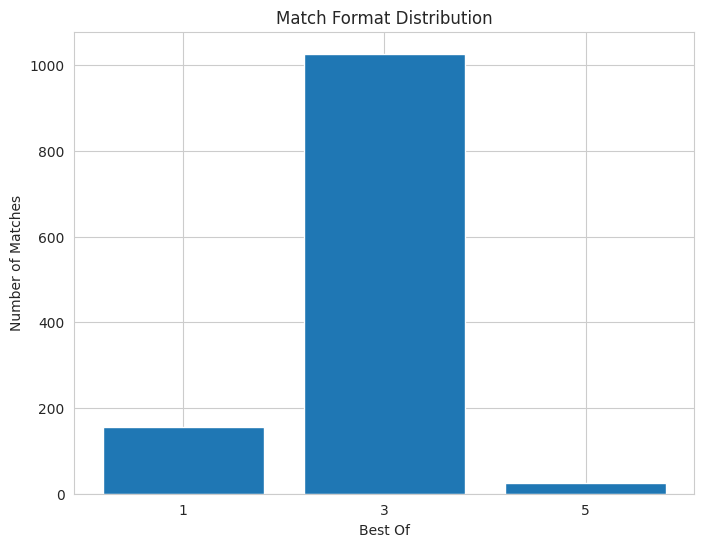

In [34]:
# Best of distribution
print("=== VETO DATA OVERVIEW ===")
print(vetos.head())

best_of_dist = vetos.group_by("best_of").agg(pl.count().alias("count")).sort("best_of")
print("\n=== BEST OF DISTRIBUTION ===")
print(best_of_dist)

# Visualize
bo_data = best_of_dist.to_pandas()
plt.figure(figsize=(8, 6))
plt.bar(bo_data["best_of"].astype(str), bo_data["count"])
plt.xlabel("Best Of")
plt.ylabel("Number of Matches")
plt.title("Match Format Distribution")
plt.show()

=== MOST BANNED MAPS ===
shape: (7, 2)
┌──────────┬───────────┐
│ map      ┆ ban_count │
│ ---      ┆ ---       │
│ str      ┆ u32       │
╞══════════╪═══════════╡
│ Overpass ┆ 859       │
│ Train    ┆ 826       │
│ Inferno  ┆ 759       │
│ Mirage   ┆ 642       │
│ Nuke     ┆ 638       │
│ Dust2    ┆ 606       │
│ Ancient  ┆ 604       │
└──────────┴───────────┘


/tmp/ipykernel_255610/605854360.py:22: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  .agg(pl.count().alias("ban_count"))


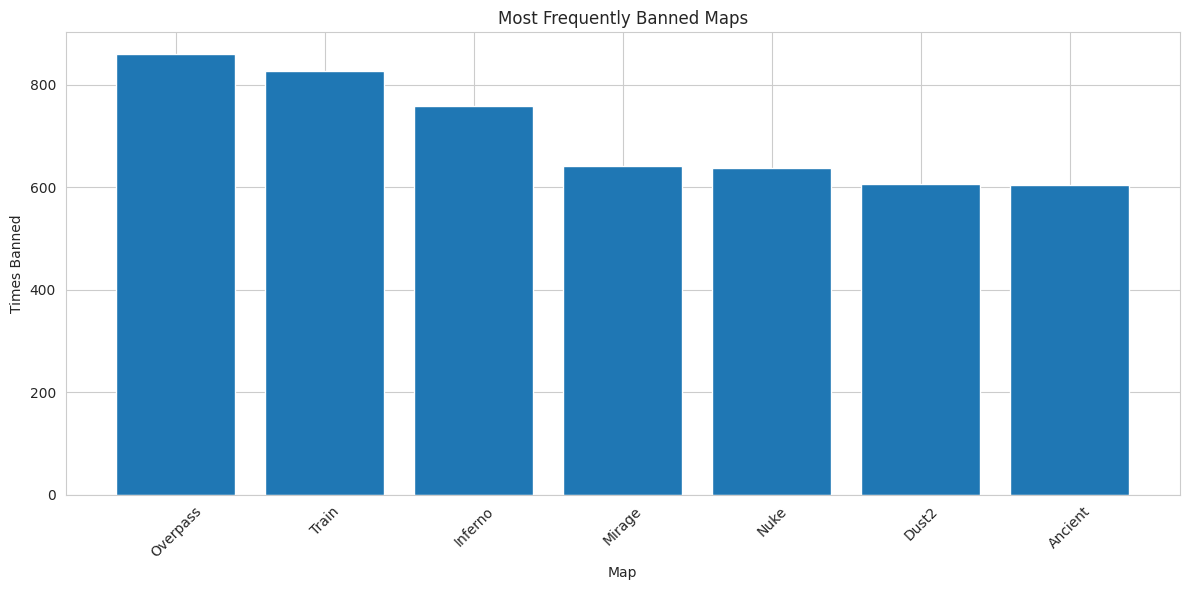

In [35]:
# Most banned maps (removals)
all_bans = []

# Collect all bans
for col in [
    "t1_removed_1",
    "t2_removed_1",
    "t1_removed_2",
    "t2_removed_2",
    "t1_removed_3",
    "t2_removed_3",
]:
    if col in vetos.columns:
        bans = vetos.filter(pl.col(col).is_not_null()).select(pl.col(col).alias("map"))
        if len(bans) > 0:
            all_bans.append(bans)

if all_bans:
    all_bans_df = pl.concat(all_bans)
    ban_counts = (
        all_bans_df.group_by("map")
        .agg(pl.count().alias("ban_count"))
        .sort("ban_count", descending=True)
    )

    print("=== MOST BANNED MAPS ===")
    print(ban_counts)

    # Visualize
    ban_data = ban_counts.to_pandas()
    plt.figure(figsize=(12, 6))
    plt.bar(ban_data["map"], ban_data["ban_count"])
    plt.xlabel("Map")
    plt.ylabel("Times Banned")
    plt.title("Most Frequently Banned Maps")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("No ban data available")

/tmp/ipykernel_255610/3309241617.py:14: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  .agg(pl.count().alias("pick_count"))


=== MOST PICKED MAPS ===
shape: (7, 2)
┌──────────┬────────────┐
│ map      ┆ pick_count │
│ ---      ┆ ---        │
│ str      ┆ u32        │
╞══════════╪════════════╡
│ Ancient  ┆ 374        │
│ Dust2    ┆ 373        │
│ Nuke     ┆ 347        │
│ Mirage   ┆ 330        │
│ Inferno  ┆ 302        │
│ Train    ┆ 221        │
│ Overpass ┆ 207        │
└──────────┴────────────┘


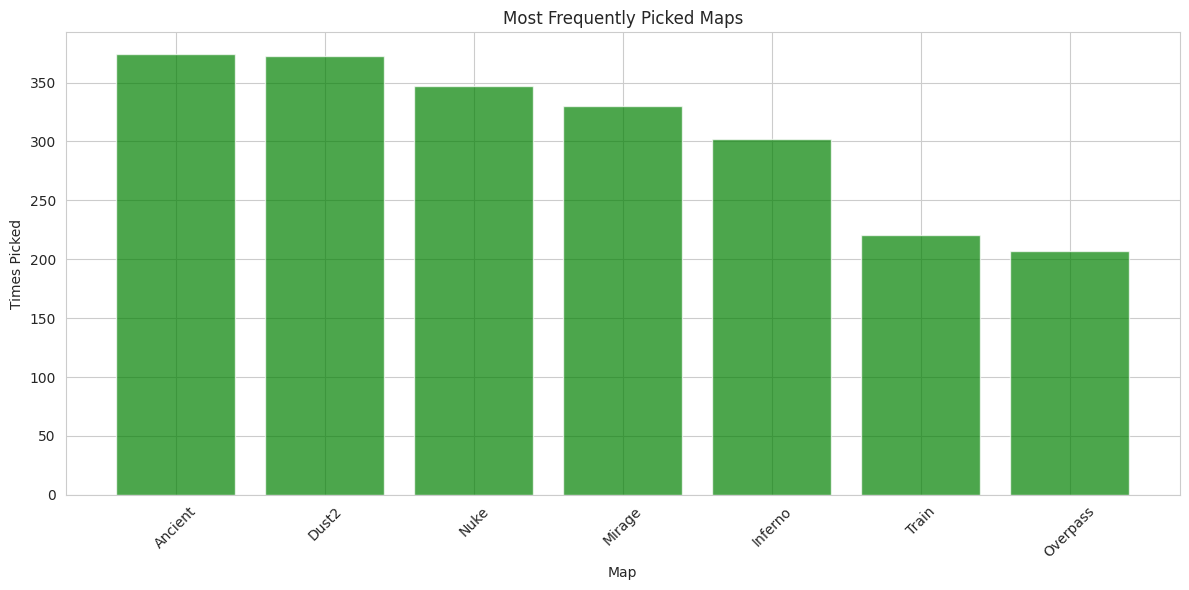

In [36]:
# Most picked maps
all_picks = []

for col in ["t1_picked_1", "t2_picked_1", "t1_picked_2", "t2_picked_2"]:
    if col in vetos.columns:
        picks = vetos.filter(pl.col(col).is_not_null()).select(pl.col(col).alias("map"))
        if len(picks) > 0:
            all_picks.append(picks)

if all_picks:
    all_picks_df = pl.concat(all_picks)
    pick_counts = (
        all_picks_df.group_by("map")
        .agg(pl.count().alias("pick_count"))
        .sort("pick_count", descending=True)
    )

    print("=== MOST PICKED MAPS ===")
    print(pick_counts)

    # Visualize
    pick_data = pick_counts.to_pandas()
    plt.figure(figsize=(12, 6))
    plt.bar(pick_data["map"], pick_data["pick_count"], color="green", alpha=0.7)
    plt.xlabel("Map")
    plt.ylabel("Times Picked")
    plt.title("Most Frequently Picked Maps")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("No pick data available")

## 5. Player Statistics Analysis

In [37]:
# Join player names with their stats
player_stats_with_names = player_map_stats.join(
    players, on="player_id", how="left"
).join(map_stats.select(["map_stat_id", "map_name"]), on="map_stat_id", how="left")

print("=== PLAYER STATS WITH NAMES ===")
print(player_stats_with_names.head(10))
print(f"\nTotal player-map records: {len(player_stats_with_names)}")

=== PLAYER STATS WITH NAMES ===
shape: (10, 32)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ map_stat_ ┆ player_id ┆ opening_k ┆ opening_d ┆ … ┆ swing_tr  ┆ rating_3_ ┆ name      ┆ map_name │
│ id        ┆ ---       ┆ ills_ct   ┆ eaths_ct  ┆   ┆ ---       ┆ dot_0_tr  ┆ ---       ┆ ---      │
│ ---       ┆ i32       ┆ ---       ┆ ---       ┆   ┆ decimal[3 ┆ ---       ┆ str       ┆ str      │
│ i32       ┆           ┆ i32       ┆ i32       ┆   ┆ 8,10]     ┆ decimal[3 ┆           ┆          │
│           ┆           ┆           ┆           ┆   ┆           ┆ 8,10]     ┆           ┆          │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 215414    ┆ 14744     ┆ 2         ┆ 0         ┆ … ┆ -7.450000 ┆ 0.7300000 ┆ calamity  ┆ Inferno  │
│           ┆           ┆           ┆           ┆   ┆ 0000      ┆ 000       ┆           ┆          │
│ 215414    ┆ 20330     ┆ 1         ┆ 2    

In [38]:
# Aggregate player performance across all maps
player_aggregate = (
    player_stats_with_names.group_by("player_id", "name")
    .agg(
        [
            pl.count().alias("maps_played"),
            # CT side stats
            pl.sum("kills_ct").alias("total_kills_ct"),
            pl.sum("deaths_ct").alias("total_deaths_ct"),
            pl.sum("assists_ct").alias("total_assists_ct"),
            pl.sum("clutches_ct").alias("total_clutches_ct"),
            pl.sum("opening_kills_ct").alias("total_opening_kills_ct"),
            pl.sum("opening_deaths_ct").alias("total_opening_deaths_ct"),
            pl.mean("rating_3_dot_0_ct").alias("avg_rating_ct"),
            pl.mean("adr_ct").alias("avg_adr_ct"),
            pl.mean("kast_ct").alias("avg_kast_ct"),
            # T side stats
            pl.sum("kills_tr").alias("total_kills_tr"),
            pl.sum("deaths_tr").alias("total_deaths_tr"),
            pl.sum("assists_tr").alias("total_assists_tr"),
            pl.sum("clutches_tr").alias("total_clutches_tr"),
            pl.sum("opening_kills_tr").alias("total_opening_kills_tr"),
            pl.sum("opening_deaths_tr").alias("total_opening_deaths_tr"),
            pl.mean("rating_3_dot_0_tr").alias("avg_rating_tr"),
            pl.mean("adr_tr").alias("avg_adr_tr"),
            pl.mean("kast_tr").alias("avg_kast_tr"),
        ]
    )
    .with_columns(
        [
            (pl.col("total_kills_ct") + pl.col("total_kills_tr")).alias("total_kills"),
            (pl.col("total_deaths_ct") + pl.col("total_deaths_tr")).alias(
                "total_deaths"
            ),
            (pl.col("total_clutches_ct") + pl.col("total_clutches_tr")).alias(
                "total_clutches"
            ),
            ((pl.col("avg_rating_ct") + pl.col("avg_rating_tr")) / 2).alias(
                "avg_rating_overall"
            ),
            ((pl.col("avg_adr_ct") + pl.col("avg_adr_tr")) / 2).alias(
                "avg_adr_overall"
            ),
        ]
    )
    .with_columns([(pl.col("total_kills") / pl.col("total_deaths")).alias("kd_ratio")])
    .filter(pl.col("maps_played") >= 5)  # Filter players with at least 5 maps
    .sort("avg_rating_overall", descending=True)
)

print("=== TOP PLAYERS BY OVERALL RATING ===")
print(
    player_aggregate.select(
        [
            "name",
            "maps_played",
            "avg_rating_overall",
            "kd_ratio",
            "total_kills",
            "total_deaths",
            "total_clutches",
            "avg_adr_overall",
        ]
    ).head(20)
)

=== TOP PLAYERS BY OVERALL RATING ===
shape: (20, 8)
┌───────────┬────────────┬────────────┬──────────┬────────────┬────────────┬───────────┬───────────┐
│ name      ┆ maps_playe ┆ avg_rating ┆ kd_ratio ┆ total_kill ┆ total_deat ┆ total_clu ┆ avg_adr_o │
│ ---       ┆ d          ┆ _overall   ┆ ---      ┆ s          ┆ hs         ┆ tches     ┆ verall    │
│ str       ┆ ---        ┆ ---        ┆ f64      ┆ ---        ┆ ---        ┆ ---       ┆ ---       │
│           ┆ u32        ┆ f64        ┆          ┆ i32        ┆ i32        ┆ i32       ┆ f64       │
╞═══════════╪════════════╪════════════╪══════════╪════════════╪════════════╪═══════════╪═══════════╡
│ rim3      ┆ 5          ┆ 1.675      ┆ 1.395062 ┆ 113        ┆ 81         ┆ 3         ┆ 107.25    │
│ DayMake   ┆ 5          ┆ 1.548      ┆ 1.344262 ┆ 82         ┆ 61         ┆ 3         ┆ 100.8     │
│ tomaszin  ┆ 15         ┆ 1.524      ┆ 1.339806 ┆ 276        ┆ 206        ┆ 5         ┆ 94.733333 │
│ Liazz     ┆ 21         ┆ 1.521667   

/tmp/ipykernel_255610/1957644116.py:6: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  pl.count().alias("maps_played"),


In [39]:
# Top players by different metrics
print("\n=== TOP 10 PLAYERS BY K/D RATIO ===")
print(
    player_aggregate.sort("kd_ratio", descending=True)
    .select(
        [
            "name",
            "maps_played",
            "kd_ratio",
            "total_kills",
            "total_deaths",
            "avg_rating_overall",
        ]
    )
    .head(10)
)

print("\n=== TOP 10 CLUTCH PLAYERS ===")
print(
    player_aggregate.sort("total_clutches", descending=True)
    .select(["name", "maps_played", "total_clutches", "avg_rating_overall"])
    .head(10)
)

print("\n=== TOP 10 PLAYERS BY ADR ===")
print(
    player_aggregate.sort("avg_adr_overall", descending=True)
    .select(["name", "maps_played", "avg_adr_overall", "avg_rating_overall"])
    .head(10)
)


=== TOP 10 PLAYERS BY K/D RATIO ===
shape: (10, 6)
┌────────────┬─────────────┬──────────┬─────────────┬──────────────┬────────────────────┐
│ name       ┆ maps_played ┆ kd_ratio ┆ total_kills ┆ total_deaths ┆ avg_rating_overall │
│ ---        ┆ ---         ┆ ---      ┆ ---         ┆ ---          ┆ ---                │
│ str        ┆ u32         ┆ f64      ┆ i32         ┆ i32          ┆ f64                │
╞════════════╪═════════════╪══════════╪═════════════╪══════════════╪════════════════════╡
│ Pluto      ┆ 7           ┆ 1.666667 ┆ 130         ┆ 78           ┆ 1.510714           │
│ Liazz      ┆ 21          ┆ 1.546667 ┆ 348         ┆ 225          ┆ 1.521667           │
│ mello      ┆ 5           ┆ 1.54386  ┆ 88          ┆ 57           ┆ 1.337              │
│ rinji      ┆ 8           ┆ 1.541176 ┆ 131         ┆ 85           ┆ 1.3875             │
│ sh1ro      ┆ 24          ┆ 1.518644 ┆ 448         ┆ 295          ┆ 1.241667           │
│ junior     ┆ 24          ┆ 1.496    ┆ 374     

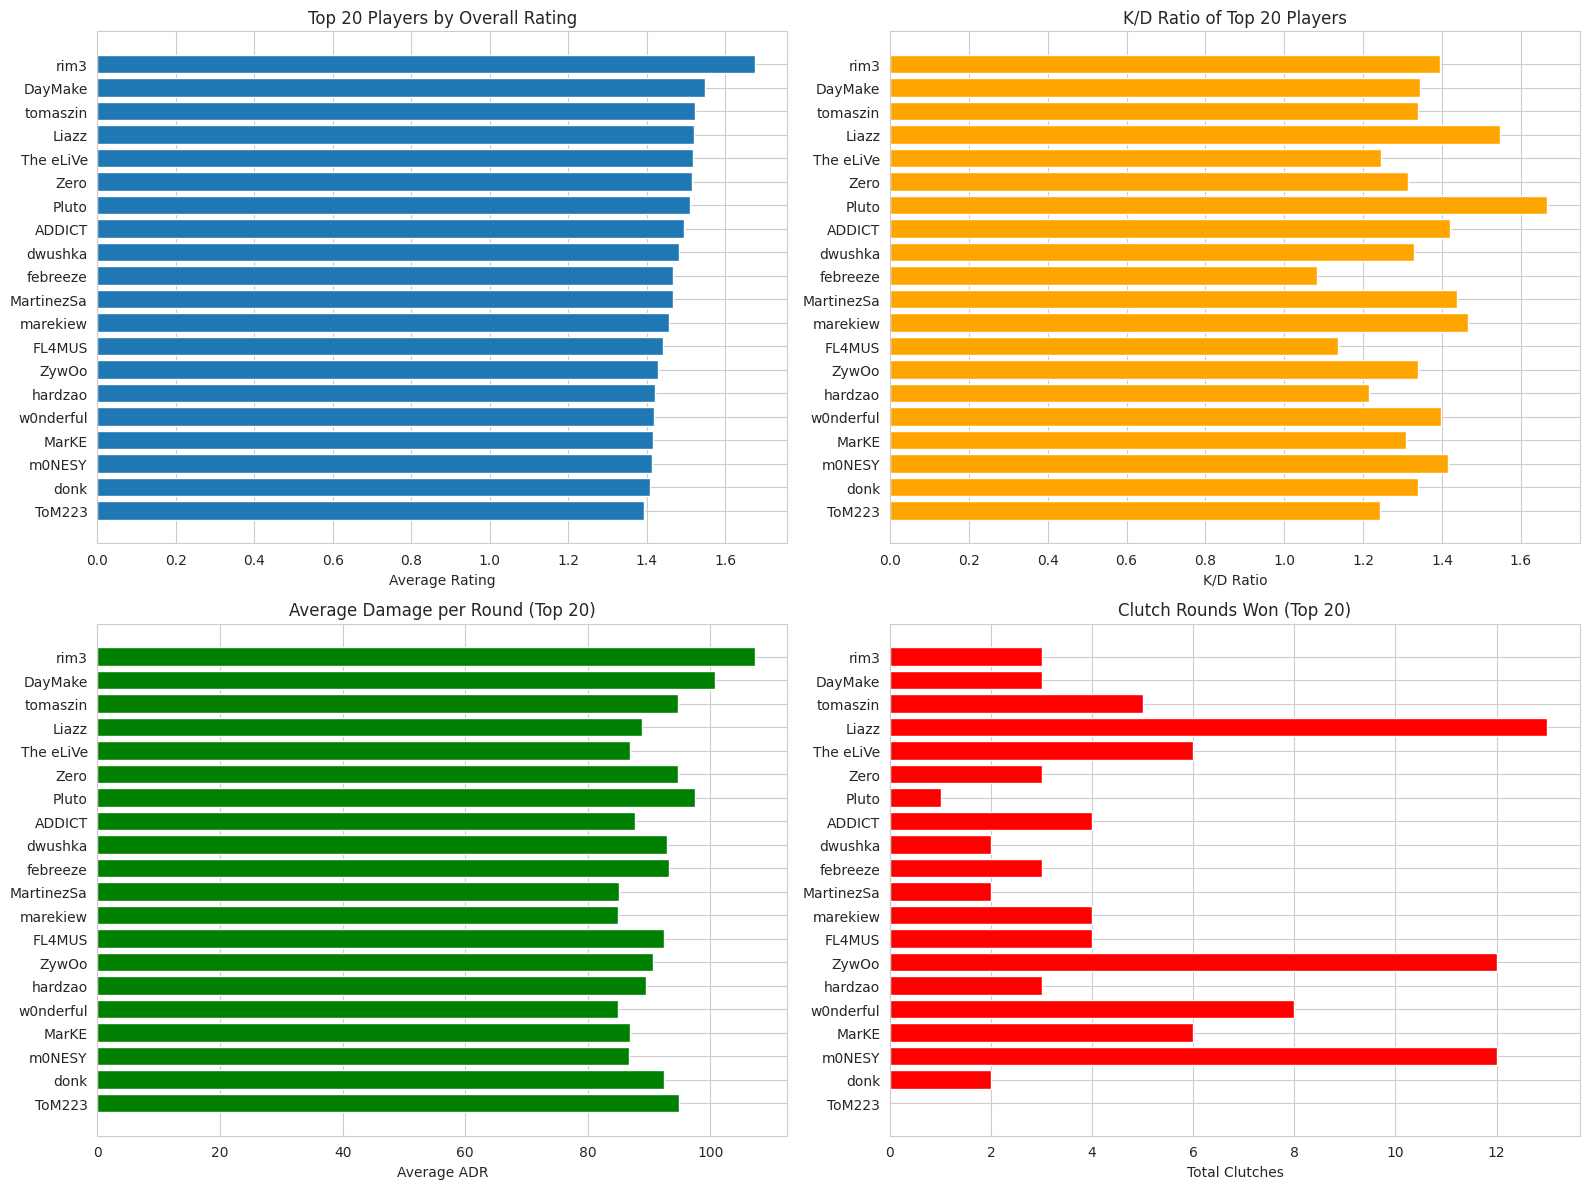

In [40]:
# Visualize top players
top_20 = player_aggregate.head(20).to_pandas()

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Rating
axes[0, 0].barh(top_20["name"], top_20["avg_rating_overall"])
axes[0, 0].set_xlabel("Average Rating")
axes[0, 0].set_title("Top 20 Players by Overall Rating")
axes[0, 0].invert_yaxis()

# K/D Ratio
axes[0, 1].barh(top_20["name"], top_20["kd_ratio"], color="orange")
axes[0, 1].set_xlabel("K/D Ratio")
axes[0, 1].set_title("K/D Ratio of Top 20 Players")
axes[0, 1].invert_yaxis()

# ADR
axes[1, 0].barh(top_20["name"], top_20["avg_adr_overall"], color="green")
axes[1, 0].set_xlabel("Average ADR")
axes[1, 0].set_title("Average Damage per Round (Top 20)")
axes[1, 0].invert_yaxis()

# Clutches
axes[1, 1].barh(top_20["name"], top_20["total_clutches"], color="red")
axes[1, 1].set_xlabel("Total Clutches")
axes[1, 1].set_title("Clutch Rounds Won (Top 20)")
axes[1, 1].invert_yaxis()

plt.tight_layout()
plt.show()

=== CT VS T SIDE PERFORMANCE (TOP 20 PLAYERS) ===
shape: (20, 7)
┌───────────┬───────────────┬───────────────┬────────────┬────────────┬─────────────┬─────────────┐
│ name      ┆ avg_rating_ct ┆ avg_rating_tr ┆ avg_adr_ct ┆ avg_adr_tr ┆ avg_kast_ct ┆ avg_kast_tr │
│ ---       ┆ ---           ┆ ---           ┆ ---        ┆ ---        ┆ ---         ┆ ---         │
│ str       ┆ f64           ┆ f64           ┆ f64        ┆ f64        ┆ f64         ┆ f64         │
╞═══════════╪═══════════════╪═══════════════╪════════════╪════════════╪═════════════╪═════════════╡
│ rim3      ┆ 1.45          ┆ 1.9           ┆ 103.9      ┆ 110.6      ┆ 74.62       ┆ 76.92       │
│ DayMake   ┆ 1.148         ┆ 1.948         ┆ 94.38      ┆ 107.22     ┆ 74.1        ┆ 80.82       │
│ tomaszin  ┆ 1.564         ┆ 1.484         ┆ 101.993333 ┆ 87.473333  ┆ 82.033333   ┆ 72.826667   │
│ Liazz     ┆ 1.332381      ┆ 1.710952      ┆ 81.419048  ┆ 96.404762  ┆ 83.6        ┆ 78.433333   │
│ The eLiVe ┆ 1.54          ┆ 1.497

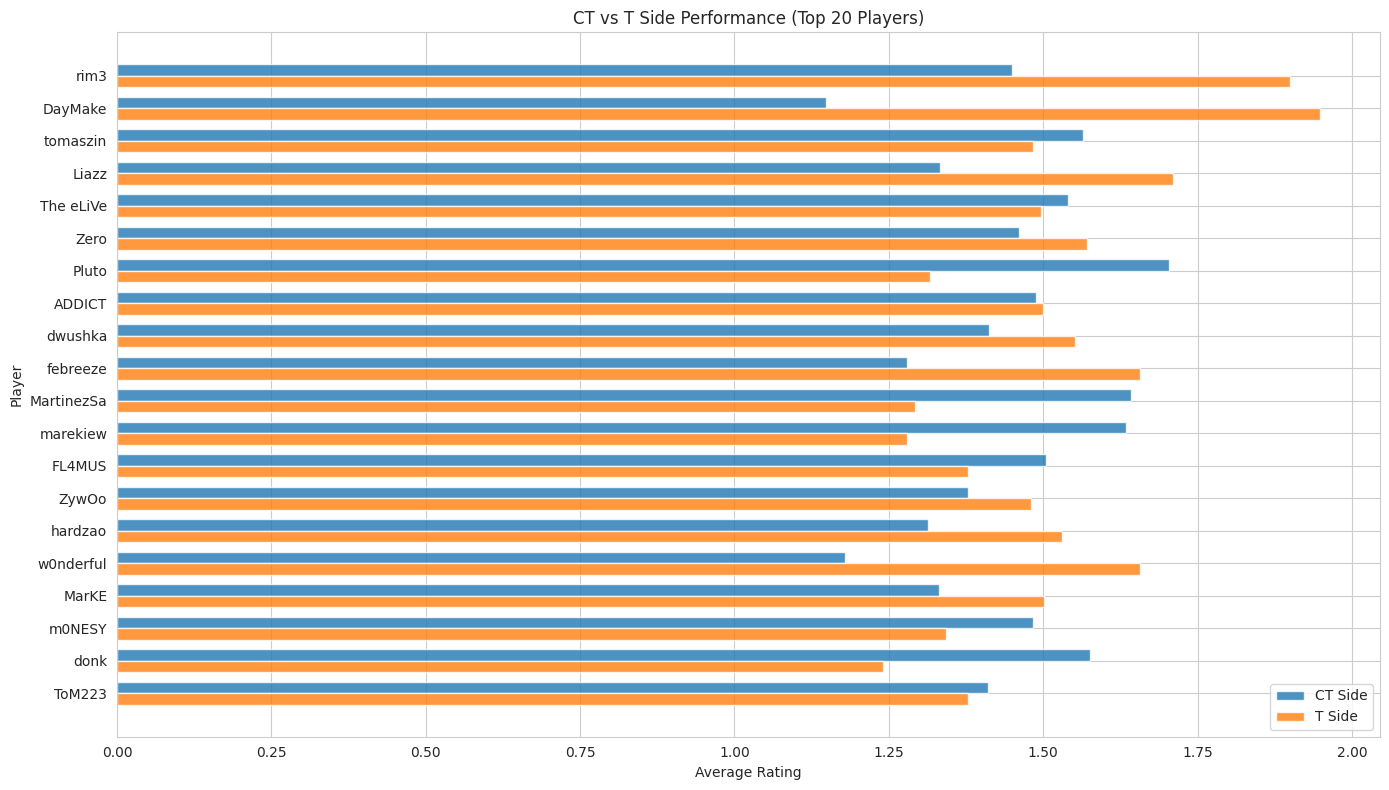

In [41]:
# CT vs T side performance comparison for top players
print("=== CT VS T SIDE PERFORMANCE (TOP 20 PLAYERS) ===")
ct_vs_t_comparison = player_aggregate.head(20).select(
    [
        "name",
        "avg_rating_ct",
        "avg_rating_tr",
        "avg_adr_ct",
        "avg_adr_tr",
        "avg_kast_ct",
        "avg_kast_tr",
    ]
)
print(ct_vs_t_comparison)

# Visualize CT vs T rating for top players
top_20_ct_t = player_aggregate.head(20).to_pandas()
x = range(len(top_20_ct_t))
width = 0.35

fig, ax = plt.subplots(figsize=(14, 8))
ax.barh(
    [i - width / 2 for i in x],
    top_20_ct_t["avg_rating_ct"],
    width,
    label="CT Side",
    alpha=0.8,
)
ax.barh(
    [i + width / 2 for i in x],
    top_20_ct_t["avg_rating_tr"],
    width,
    label="T Side",
    alpha=0.8,
)
ax.set_ylabel("Player")
ax.set_xlabel("Average Rating")
ax.set_title("CT vs T Side Performance (Top 20 Players)")
ax.set_yticks(x)
ax.set_yticklabels(top_20_ct_t["name"])
ax.legend()
ax.invert_yaxis()
plt.tight_layout()
plt.show()

=== TOP 15 PLAYERS IN OPENING DUELS ===
shape: (15, 6)
┌──────────┬─────────────┬──────────────────┬──────────────────┬─────────────────┬─────────────────┐
│ name     ┆ maps_played ┆ total_opening_ki ┆ total_opening_de ┆ opening_success ┆ avg_rating_over │
│ ---      ┆ ---         ┆ lls              ┆ aths             ┆ _rate           ┆ all             │
│ str      ┆ u32         ┆ ---              ┆ ---              ┆ ---             ┆ ---             │
│          ┆             ┆ i32              ┆ i32              ┆ f64             ┆ f64             │
╞══════════╪═════════════╪══════════════════╪══════════════════╪═════════════════╪═════════════════╡
│ rinji    ┆ 8           ┆ 19               ┆ 5                ┆ 0.791667        ┆ 1.3875          │
│ DayMake  ┆ 5           ┆ 17               ┆ 5                ┆ 0.772727        ┆ 1.548           │
│ consti   ┆ 17          ┆ 46               ┆ 14               ┆ 0.766667        ┆ 1.302941        │
│ xm1nd    ┆ 20          ┆ 48       

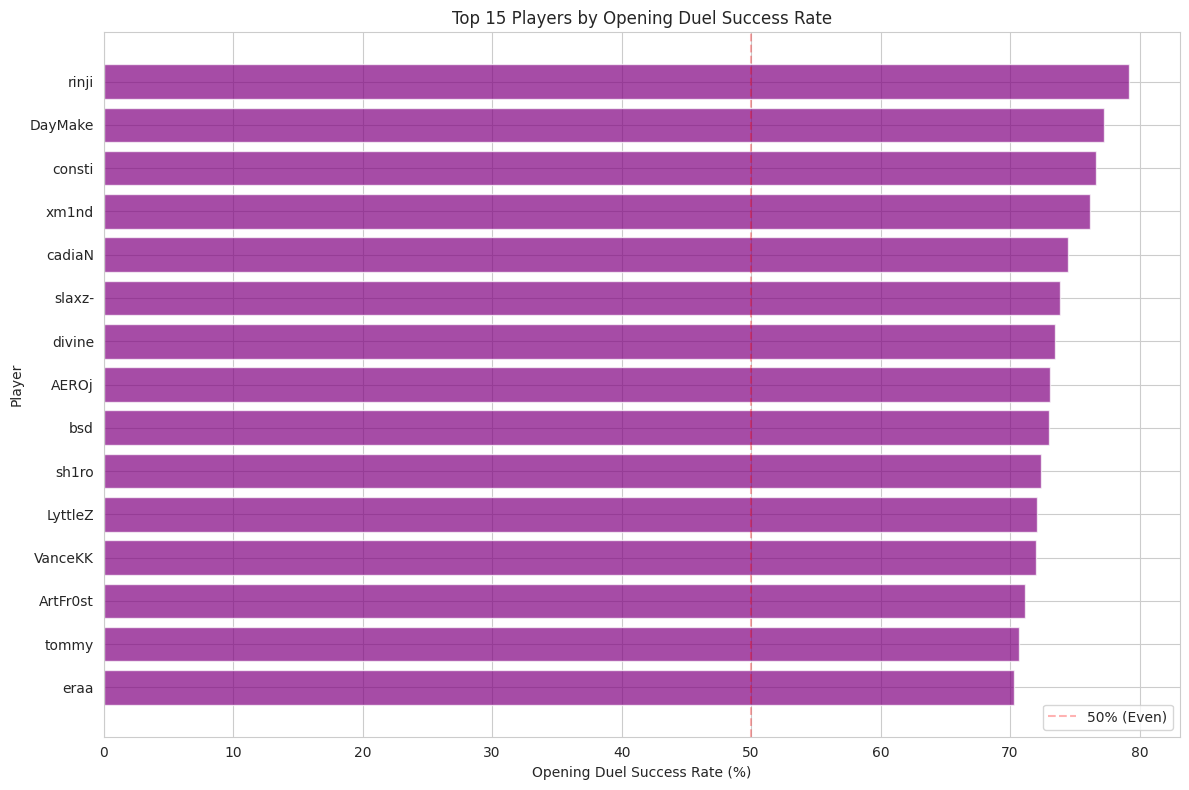

In [42]:
# Opening duels analysis
opening_duels = (
    player_aggregate.with_columns(
        [
            (pl.col("total_opening_kills_ct") + pl.col("total_opening_kills_tr")).alias(
                "total_opening_kills"
            ),
            (
                pl.col("total_opening_deaths_ct") + pl.col("total_opening_deaths_tr")
            ).alias("total_opening_deaths"),
        ]
    )
    .with_columns(
        [
            (
                pl.col("total_opening_kills")
                / (pl.col("total_opening_kills") + pl.col("total_opening_deaths"))
            ).alias("opening_success_rate")
        ]
    )
    .filter(
        (pl.col("total_opening_kills") + pl.col("total_opening_deaths"))
        >= 20  # At least 20 opening duels
    )
    .sort("opening_success_rate", descending=True)
)

print("=== TOP 15 PLAYERS IN OPENING DUELS ===")
print(
    opening_duels.select(
        [
            "name",
            "maps_played",
            "total_opening_kills",
            "total_opening_deaths",
            "opening_success_rate",
            "avg_rating_overall",
        ]
    ).head(15)
)

# Visualize
opening_top15 = opening_duels.head(15).to_pandas()
plt.figure(figsize=(12, 8))
plt.barh(
    opening_top15["name"],
    opening_top15["opening_success_rate"] * 100,
    color="purple",
    alpha=0.7,
)
plt.xlabel("Opening Duel Success Rate (%)")
plt.ylabel("Player")
plt.title("Top 15 Players by Opening Duel Success Rate")
plt.axvline(x=50, color="r", linestyle="--", alpha=0.3, label="50% (Even)")
plt.legend()
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## 6. Player Performance by Map

In [43]:
# Player performance aggregated by map
player_by_map = (
    player_stats_with_names.group_by("map_name", "player_id", "name")
    .agg(
        [
            pl.count().alias("times_played"),
            pl.mean("rating_3_dot_0_ct").alias("avg_rating_ct"),
            pl.mean("rating_3_dot_0_tr").alias("avg_rating_tr"),
            pl.sum("kills_ct").alias("total_kills_ct"),
            pl.sum("kills_tr").alias("total_kills_tr"),
            pl.sum("deaths_ct").alias("total_deaths_ct"),
            pl.sum("deaths_tr").alias("total_deaths_tr"),
        ]
    )
    .with_columns(
        [
            ((pl.col("avg_rating_ct") + pl.col("avg_rating_tr")) / 2).alias(
                "avg_rating"
            ),
            (pl.col("total_kills_ct") + pl.col("total_kills_tr")).alias("total_kills"),
            (pl.col("total_deaths_ct") + pl.col("total_deaths_tr")).alias(
                "total_deaths"
            ),
        ]
    )
    .with_columns([(pl.col("total_kills") / pl.col("total_deaths")).alias("kd_ratio")])
    .filter(pl.col("times_played") >= 3)  # At least 3 times on the map
    .sort(["map_name", "avg_rating"], descending=[False, True])
)

print("=== PLAYER PERFORMANCE BY MAP ===")
print(player_by_map.head(20))

=== PLAYER PERFORMANCE BY MAP ===
shape: (20, 14)
┌──────────┬───────────┬───────────┬────────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ map_name ┆ player_id ┆ name      ┆ times_play ┆ … ┆ avg_ratin ┆ total_kil ┆ total_dea ┆ kd_ratio │
│ ---      ┆ ---       ┆ ---       ┆ ed         ┆   ┆ g         ┆ ls        ┆ ths       ┆ ---      │
│ str      ┆ i32       ┆ str       ┆ ---        ┆   ┆ ---       ┆ ---       ┆ ---       ┆ f64      │
│          ┆           ┆           ┆ u32        ┆   ┆ f64       ┆ i32       ┆ i32       ┆          │
╞══════════╪═══════════╪═══════════╪════════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ Ancient  ┆ 22570     ┆ tomaszin  ┆ 5          ┆ … ┆ 1.922     ┆ 110       ┆ 71        ┆ 1.549296 │
│ Ancient  ┆ 11840     ┆ Boombl4   ┆ 4          ┆ … ┆ 1.83625   ┆ 66        ┆ 41        ┆ 1.609756 │
│ Ancient  ┆ 16080     ┆ dycha     ┆ 4          ┆ … ┆ 1.6325    ┆ 77        ┆ 50        ┆ 1.54     │
│ Ancient  ┆ 23600     ┆ Alkaren   ┆ 4   

/tmp/ipykernel_255610/1334273738.py:6: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  pl.count().alias("times_played"),


In [44]:
# Find best players for each map
best_players_per_map = (
    player_by_map.sort(["map_name", "avg_rating"], descending=[False, True])
    .group_by("map_name")
    .agg(
        [
            pl.col("name").first().alias("best_player"),
            pl.col("avg_rating").first().alias("best_rating"),
            pl.col("times_played").first().alias("maps_played"),
            pl.col("kd_ratio").first().alias("kd_ratio"),
        ]
    )
    .sort("map_name")
)

print("=== BEST PLAYER FOR EACH MAP ===")
print(best_players_per_map)

=== BEST PLAYER FOR EACH MAP ===
shape: (7, 5)
┌──────────┬─────────────┬─────────────┬─────────────┬──────────┐
│ map_name ┆ best_player ┆ best_rating ┆ maps_played ┆ kd_ratio │
│ ---      ┆ ---         ┆ ---         ┆ ---         ┆ ---      │
│ str      ┆ str         ┆ f64         ┆ u32         ┆ f64      │
╞══════════╪═════════════╪═════════════╪═════════════╪══════════╡
│ Ancient  ┆ tomaszin    ┆ 1.922       ┆ 5           ┆ 1.549296 │
│ Dust2    ┆ ct0m        ┆ 2.24        ┆ 3           ┆ 2.461538 │
│ Inferno  ┆ WolfY       ┆ 1.72        ┆ 11          ┆ 1.94186  │
│ Mirage   ┆ Zero        ┆ 2.081667    ┆ 3           ┆ 1.756757 │
│ Nuke     ┆ Infinite    ┆ 1.875       ┆ 3           ┆ 1.666667 │
│ Overpass ┆ Banjo       ┆ 1.868333    ┆ 3           ┆ 1.212121 │
│ Train    ┆ Texta       ┆ 1.88625     ┆ 4           ┆ 1.488889 │
└──────────┴─────────────┴─────────────┴─────────────┴──────────┘


## 7. Statistical Correlations and Insights

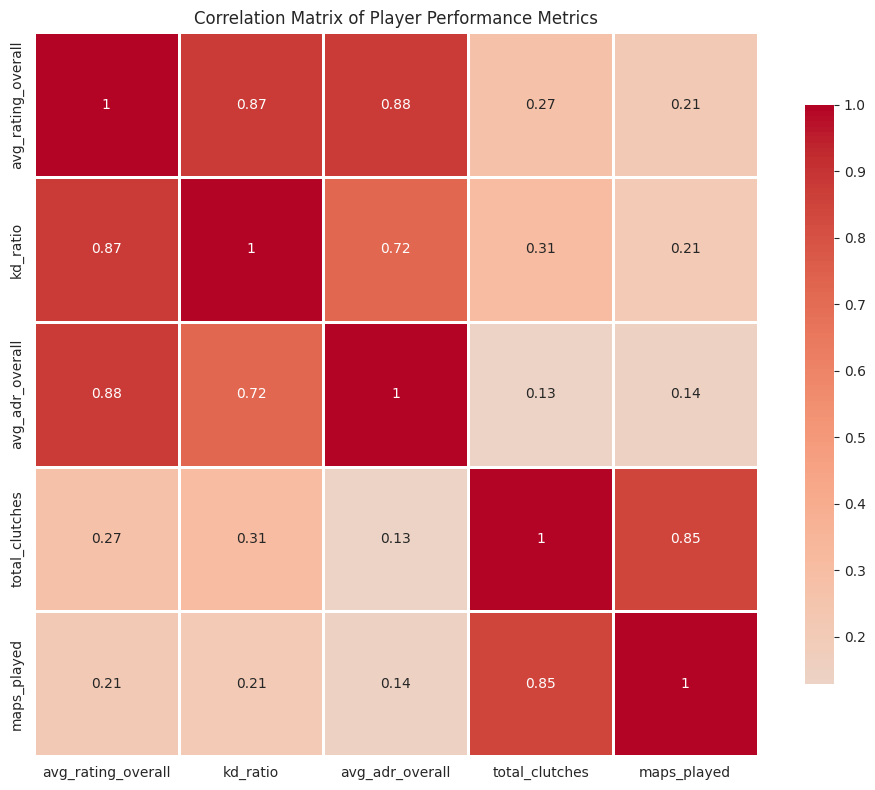


=== CORRELATION MATRIX ===
                    avg_rating_overall  kd_ratio  avg_adr_overall  \
avg_rating_overall            1.000000  0.874977         0.877922   
kd_ratio                      0.874977  1.000000         0.723098   
avg_adr_overall               0.877922  0.723098         1.000000   
total_clutches                0.270040  0.307175         0.129029   
maps_played                   0.212342  0.209696         0.142375   

                    total_clutches  maps_played  
avg_rating_overall        0.270040     0.212342  
kd_ratio                  0.307175     0.209696  
avg_adr_overall           0.129029     0.142375  
total_clutches            1.000000     0.847787  
maps_played               0.847787     1.000000  


In [45]:
# Correlation between different metrics
correlation_data = player_aggregate.select(
    [
        "avg_rating_overall",
        "kd_ratio",
        "avg_adr_overall",
        "total_clutches",
        "maps_played",
    ]
).to_pandas()

# Create correlation matrix
corr_matrix = correlation_data.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix,
    annot=True,
    cmap="coolwarm",
    center=0,
    square=True,
    linewidths=1,
    cbar_kws={"shrink": 0.8},
)
plt.title("Correlation Matrix of Player Performance Metrics")
plt.tight_layout()
plt.show()

print("\n=== CORRELATION MATRIX ===")
print(corr_matrix)

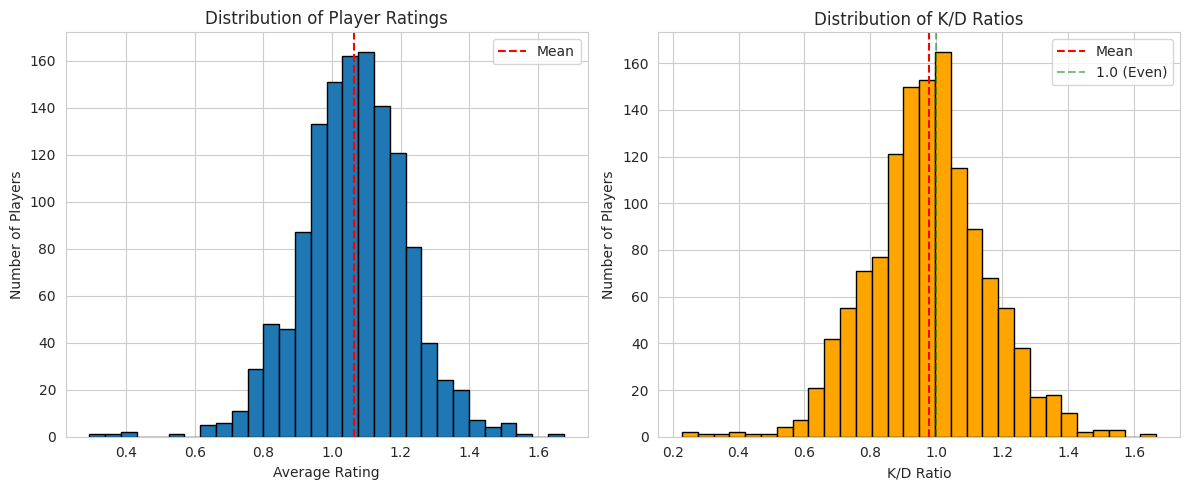

In [46]:
# Distribution of player ratings
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
player_aggregate.to_pandas()["avg_rating_overall"].hist(bins=30, edgecolor="black")
plt.xlabel("Average Rating")
plt.ylabel("Number of Players")
plt.title("Distribution of Player Ratings")
plt.axvline(
    player_aggregate.to_pandas()["avg_rating_overall"].mean(),
    color="r",
    linestyle="--",
    label="Mean",
)
plt.legend()

plt.subplot(1, 2, 2)
player_aggregate.to_pandas()["kd_ratio"].hist(
    bins=30, edgecolor="black", color="orange"
)
plt.xlabel("K/D Ratio")
plt.ylabel("Number of Players")
plt.title("Distribution of K/D Ratios")
plt.axvline(
    player_aggregate.to_pandas()["kd_ratio"].mean(),
    color="r",
    linestyle="--",
    label="Mean",
)
plt.axvline(1.0, color="g", linestyle="--", alpha=0.5, label="1.0 (Even)")
plt.legend()

plt.tight_layout()
plt.show()

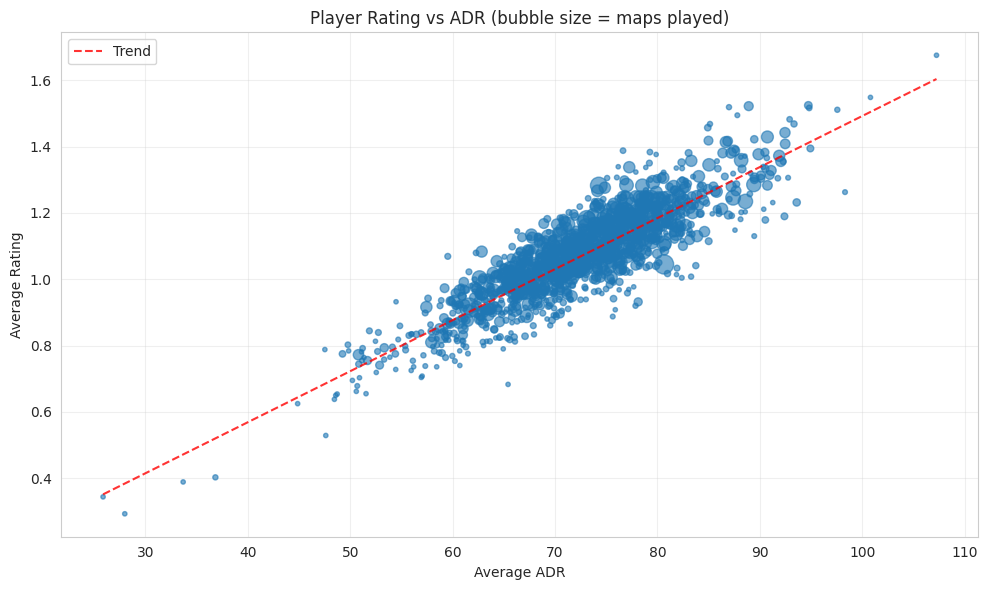

In [47]:
# Scatter plot: Rating vs ADR
plt.figure(figsize=(10, 6))
scatter_data = player_aggregate.to_pandas()
plt.scatter(
    scatter_data["avg_adr_overall"],
    scatter_data["avg_rating_overall"],
    alpha=0.6,
    s=scatter_data["maps_played"] * 2,
)
plt.xlabel("Average ADR")
plt.ylabel("Average Rating")
plt.title("Player Rating vs ADR (bubble size = maps played)")
plt.grid(True, alpha=0.3)

# Add trend line
z = np.polyfit(
    scatter_data["avg_adr_overall"].dropna(),
    scatter_data["avg_rating_overall"].dropna(),
    1,
)
p = np.poly1d(z)
plt.plot(
    scatter_data["avg_adr_overall"].sort_values(),
    p(scatter_data["avg_adr_overall"].sort_values()),
    "r--",
    alpha=0.8,
    label="Trend",
)
plt.legend()
plt.tight_layout()
plt.show()

## 8. Match and Team Analysis

=== TOP 15 TEAMS BY WINS ===
shape: (15, 3)
┌────────────────┬─────────────────┬──────┐
│ team_winner_id ┆ team_name       ┆ wins │
│ ---            ┆ ---             ┆ ---  │
│ i32            ┆ str             ┆ u32  │
╞════════════════╪═════════════════╪══════╡
│ 13027          ┆ Nuclear TigeRES ┆ 27   │
│ 13470          ┆ Oramond         ┆ 26   │
│ 12895          ┆ K27             ┆ 25   │
│ 13214          ┆ SPARTA          ┆ 21   │
│ 12857          ┆ FORZE Reload    ┆ 20   │
│ …              ┆ …               ┆ …    │
│ 12380          ┆ CYBERSHOKE      ┆ 16   │
│ 13286          ┆ FUT             ┆ 15   │
│ 4548           ┆ CPH Wolves      ┆ 13   │
│ 12394          ┆ BetBoom         ┆ 13   │
│ 12604          ┆ Johnny Speeds   ┆ 12   │
└────────────────┴─────────────────┴──────┘


/tmp/ipykernel_255610/1771474601.py:10: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  .agg([pl.count().alias("wins")])


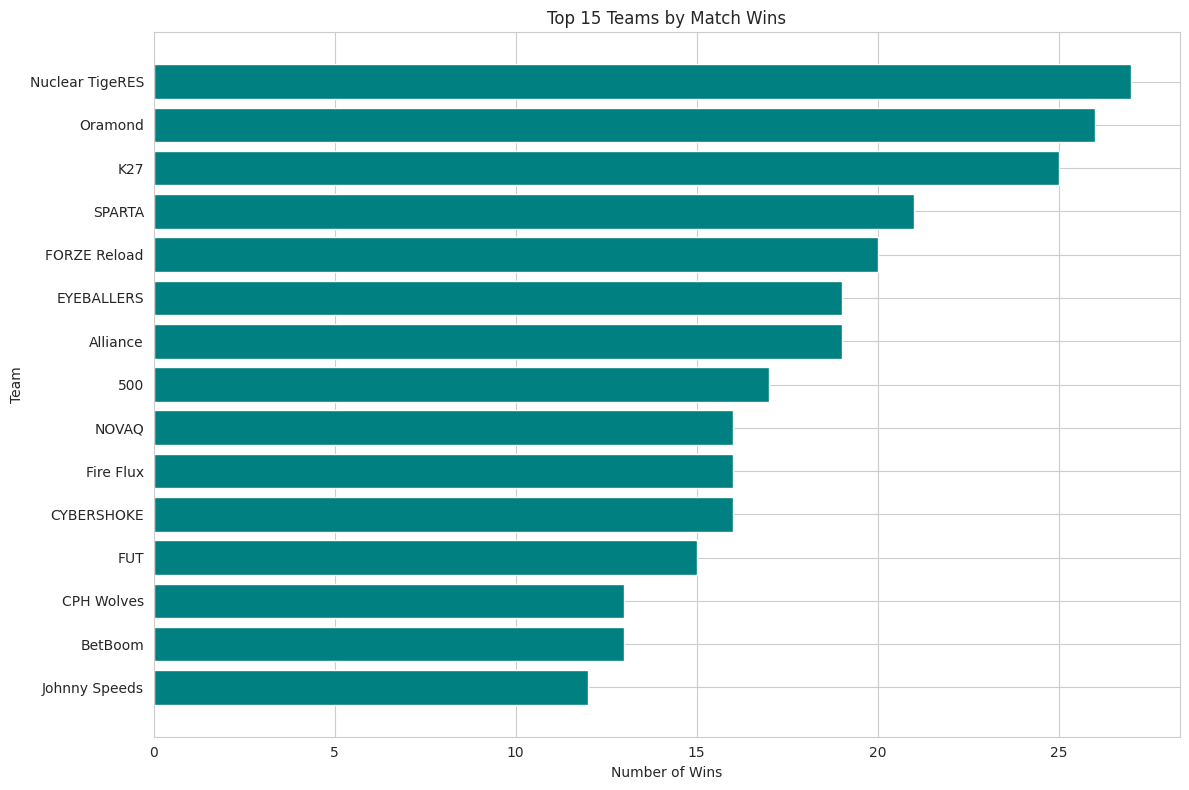

In [48]:
# Team statistics
team_performance = (
    matches.join(
        teams.select(["team_id", pl.col("name").alias("team_name")]),
        left_on="team_winner_id",
        right_on="team_id",
        how="left",
    )
    .group_by("team_winner_id", "team_name")
    .agg([pl.count().alias("wins")])
    .filter(pl.col("team_winner_id").is_not_null())
    .sort("wins", descending=True)
)

print("=== TOP 15 TEAMS BY WINS ===")
print(team_performance.head(15))

# Visualize
top_teams = team_performance.head(15).to_pandas()
plt.figure(figsize=(12, 8))
plt.barh(top_teams["team_name"], top_teams["wins"], color="teal")
plt.xlabel("Number of Wins")
plt.ylabel("Team")
plt.title("Top 15 Teams by Match Wins")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [49]:
# Match score distribution
match_score_dist = (
    matches.filter(pl.col("team_winner_id").is_not_null())
    .group_by(["team_1_map_score", "team_2_map_score"])
    .agg(pl.count().alias("count"))
    .sort("count", descending=True)
)

print("=== MATCH SCORE DISTRIBUTION ===")
print(match_score_dist.head(20))

# Event analysis
event_stats = (
    matches.join(events, on="event_id", how="left")
    .group_by("event_id", "name")
    .agg(
        [
            pl.count().alias("num_matches"),
        ]
    )
    .sort("num_matches", descending=True)
)

print("\n=== TOP EVENTS BY NUMBER OF MATCHES ===")
print(event_stats.head(10))

=== MATCH SCORE DISTRIBUTION ===
shape: (20, 3)
┌──────────────────┬──────────────────┬───────┐
│ team_1_map_score ┆ team_2_map_score ┆ count │
│ ---              ┆ ---              ┆ ---   │
│ i32              ┆ i32              ┆ u32   │
╞══════════════════╪══════════════════╪═══════╡
│ 2                ┆ 0                ┆ 342   │
│ 0                ┆ 2                ┆ 273   │
│ 2                ┆ 1                ┆ 204   │
│ 1                ┆ 2                ┆ 200   │
│ 10               ┆ 13               ┆ 12    │
│ …                ┆ …                ┆ …     │
│ 6                ┆ 13               ┆ 7     │
│ 5                ┆ 13               ┆ 7     │
│ 3                ┆ 0                ┆ 6     │
│ 3                ┆ 1                ┆ 6     │
│ 1                ┆ 0                ┆ 6     │
└──────────────────┴──────────────────┴───────┘

=== TOP EVENTS BY NUMBER OF MATCHES ===
shape: (10, 3)
┌──────────┬─────────────────────────────────┬─────────────┐
│ event_id ┆ name  

/tmp/ipykernel_255610/200254231.py:5: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  .agg(pl.count().alias("count"))
/tmp/ipykernel_255610/200254231.py:18: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  pl.count().alias("num_matches"),


## 9. Export Data to Parquet Files

In [50]:
# Create a data directory if it doesn't exist
import os

data_dir = Path.cwd().parent / "data"
os.makedirs(data_dir, exist_ok=True)

# Export all dataframes to parquet
events.write_parquet(data_dir / "events.parquet")
teams.write_parquet(data_dir / "teams.parquet")
players.write_parquet(data_dir / "players.parquet")
matches.write_parquet(data_dir / "matches.parquet")
vetos.write_parquet(data_dir / "vetos.parquet")
map_stats.write_parquet(data_dir / "map_stats.parquet")
player_map_stats.write_parquet(data_dir / "player_map_stats.parquet")

# Export aggregated analysis dataframes
player_aggregate.write_parquet(data_dir / "player_aggregate.parquet")
player_by_map.write_parquet(data_dir / "player_by_map.parquet")
map_popularity.write_parquet(data_dir / "map_popularity.parquet")
ct_t_analysis.write_parquet(data_dir / "ct_t_analysis.parquet")
team_performance.write_parquet(data_dir / "team_performance.parquet")

print("✓ All data exported to parquet files successfully!")
print(f"\nFiles saved in: {data_dir}")
print("\nExported files:")
for f in sorted(data_dir.glob("*.parquet")):
    print(f"  - {f.name}")

✓ All data exported to parquet files successfully!

Files saved in: /home/flemis/codes/clutch-or-predict/data

Exported files:
  - ct_t_analysis.parquet
  - events.parquet
  - map_popularity.parquet
  - map_stats.parquet
  - matches.parquet
  - player_aggregate.parquet
  - player_by_map.parquet
  - player_map_stats.parquet
  - players.parquet
  - team_performance.parquet
  - teams.parquet
  - vetos.parquet


## 10. Summary and Key Insights

This EDA provides comprehensive analysis of CS2 HLTV data including:

### Map Analysis
- Map popularity and play frequency
- CT vs T side balance across different maps
- Overtime statistics and trends

### Veto Patterns
- Best-of format distribution
- Most banned and picked maps
- Team preferences in map selection

### Player Performance
- Top players by rating, K/D ratio, ADR, and clutches
- CT vs T side performance comparison
- Opening duel success rates
- Player specialization on specific maps

### Statistical Insights
- Correlation between performance metrics
- Distribution of player ratings and K/D ratios
- Relationship between ADR and overall rating

### Team and Match Analysis
- Team win statistics
- Match score distributions
- Event coverage

All data has been exported to parquet files for further analysis and modeling.